In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!ls -l

total 8
-rw-r--r-- 1 root root   67 Oct  3 09:52 kaggle.json
drwxr-xr-x 1 root root 4096 Oct  1 13:39 sample_data


In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list -s pneumonia

ref                                                      title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
paultimothymooney/chest-xray-pneumonia                   Chest X-Ray Images (Pneumonia)                       2463365435  2018-03-24 19:41:59.603000         547544       7161  0.75             
pcbreviglieri/pneumonia-xray-images                      Pneumonia X-Ray Images                               1225740412  2020-05-18 14:32:09.660000          11589         98  0.9375           
andrewmvd/pediatric-pneumonia-chest-xray                 Pediatric Pneumonia Chest X-ray                      1226136448  2020-03-18 09:11:56.440000           4948         69  0.875            
artyomkolas/3-kinds-of-pneumon

In [7]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:21<00:00, 238MB/s]
100% 2.29G/2.29G [00:21<00:00, 117MB/s]


In [8]:
!unzip chest-xray-pneumonia.zip -d chest_xray

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/train

In [9]:
!ls chest_xray/chest_xray

chest_xray  __MACOSX  test  train  val


In [35]:
# Importing libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D,Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import cv2

In [22]:
# Define image size and batch size
img_size = 224
batch_size = 32

In [14]:
# Setup Data Generators
# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    zoom_range = 0.1,
    horizontal_flip = True
)

# Validation and Test data (only rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_data = train_datagen.flow_from_directory(
    "/content/chest_xray/chest_xray/train",
    target_size = (img_size,img_size),
    batch_size = batch_size,
    class_mode = 'binary'
)

val_data = val_datagen.flow_from_directory(
    "/content/chest_xray/chest_xray/val",
    target_size = (img_size,img_size),
    batch_size = batch_size,
    class_mode = 'binary'
)

test_data = val_datagen.flow_from_directory(
    "/content/chest_xray/chest_xray/test",
    target_size = (img_size,img_size),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [23]:
# Build Model(ResNet50)
inputs = Input(shape=(img_size,img_size,3))
base_model = ResNet50(weights=None,include_top=False,input_tensor=inputs)

# Freeze layers
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 23,796,993 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [24]:
#Train Model

history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=10)  # increase to 10–15 for stronger results


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 179s 724ms/step - accuracy: 0.8509 - loss: 0.3416 - val_accuracy: 0.5000 - val_loss: 7.1948
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 677ms/step - accuracy: 0.9276 - loss: 0.1920 - val_accuracy: 0.5000 - val_loss: 10.4058
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 677ms/step - accuracy: 0.9340 - loss: 0.1740 - val_accuracy: 0.5000 - val_loss: 10.5710
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 685ms/step - accuracy: 0.9469 - loss: 0.1449 - val_accuracy: 0.4375 - val_loss: 0.8022
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 676ms/step - accuracy: 0.9445 - loss: 0.1503 - val_accuracy: 0.5000 - val_loss: 2.5169
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 682ms/step - accuracy: 0.9500 - loss: 0.1413 - val_accuracy: 0.5000 - val_loss: 2.9686
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 676ms/step - accuracy: 0.9600 - loss: 0.1206 - val_accuracy: 0.5000 - val_loss: 1.4994
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 687ms/step - accuracy: 0.9614

In [25]:
# Evaluate Model

test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc*100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 0.3422 - loss: 2.9820
Test Accuracy: 64.74%


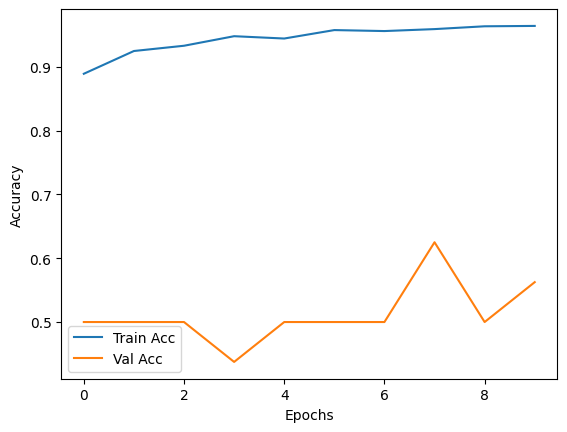

In [26]:
# Training Curves

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step
              precision    recall  f1-score   support

      NORMAL       1.00      0.06      0.11       234
   PNEUMONIA       0.64      1.00      0.78       390

    accuracy                           0.65       624
   macro avg       0.82      0.53      0.45       624
weighted avg       0.77      0.65      0.53       624



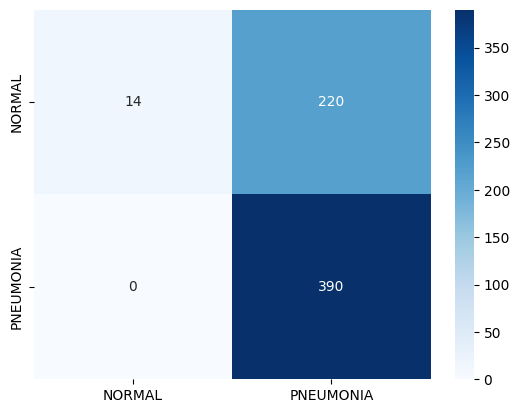

In [32]:
# Classification Report + Confusion Matrix

preds = (model.predict(test_data) > 0.5).astype("int32")

print(classification_report(test_data.classes, preds, target_names=["NORMAL","PNEUMONIA"]))

cm = confusion_matrix(test_data.classes, preds)
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues",
            xticklabels=["NORMAL","PNEUMONIA"],
            yticklabels=["NORMAL","PNEUMONIA"])
plt.show()


In [36]:
# Grad-CAM Function

def get_gradcam(full_model, img_array, layer_name='conv5_block3_out'):
  grad_model = Model(inputs=full_model.input,
                     outputs=[full_model.get_layer(layer_name).output,
                              full_model.output])
  with tf.GradientTape() as tape:
      conv_outputs, predictions = grad_model(img_array)
      loss = predictions[:,0]
  grads = tape.gradient(loss, conv_outputs)[0]
  weights = tf.reduce_mean(grads, axis=(0,1))
  cam = np.dot(conv_outputs[0], weights.numpy())
  cam = cv2.resize(cam, (img_size, img_size))
  cam = np.maximum(cam, 0)
  if cam.max() != 0:
    cam = cam / cam.max()
  return cam, predictions.numpy()[0][0]

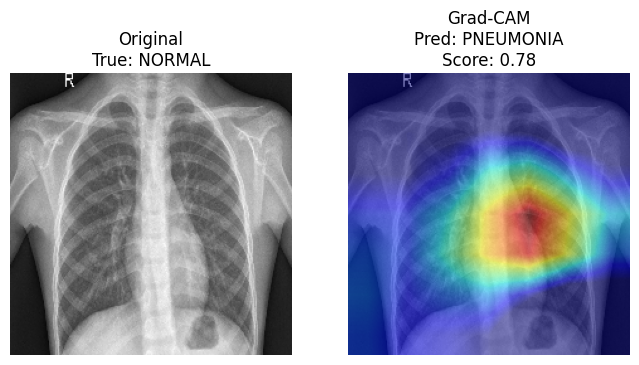

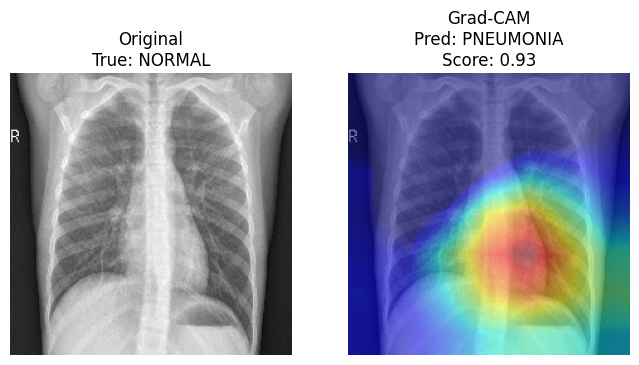

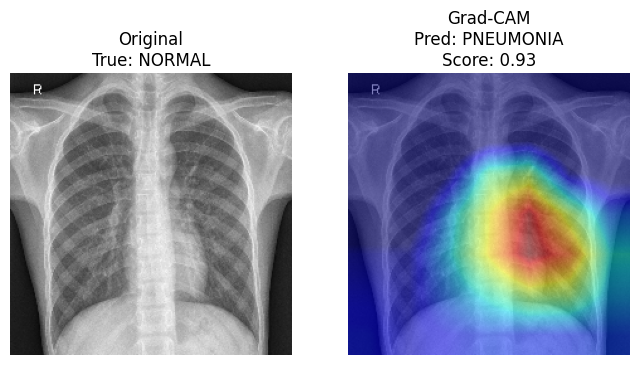

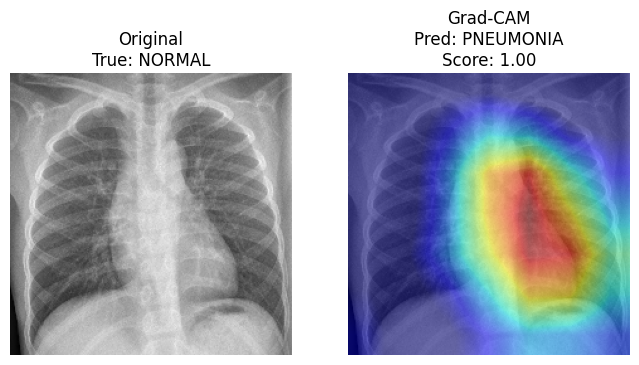

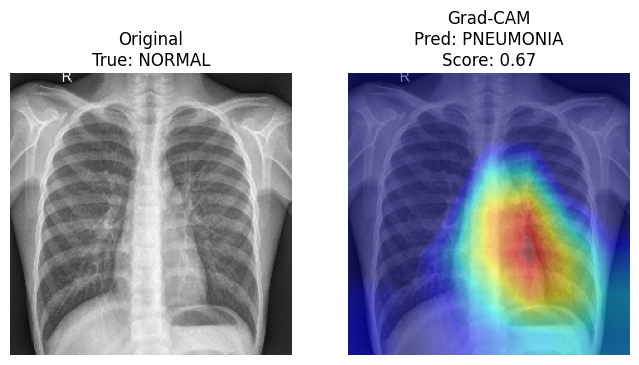

In [38]:
# Grad-CAM on Test Images

class_labels = {0: "NORMAL", 1: "PNEUMONIA"}

for i in range(5):
  img_path = test_data.filepaths[i]
  img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size,img_size))
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = np.expand_dims(img_array/255.0, axis=0)


  cam,score = get_gradcam(model, img_array, "conv5_block3_out")
  pred_class = 1 if score > 0.5 else 0
  pred_label = class_labels[pred_class]

  plt.figure(figsize=(8,4))
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.title(f"Original\nTrue: {img_path.split('/')[-2]}")
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(img)
  plt.imshow(cam, cmap='jet', alpha=0.5)
  plt.title(f"Grad-CAM\nPred: {pred_label}\nScore: {score:.2f}")
  plt.axis('off')
  plt.show()